In [1]:
#!/usr/bin/env python

# Grid_scale_scaling.ipynb

In [1]:
'''File name: Grid_scale_scaling.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 28.06.2022
    Date last modified: 28.06.2022

    ############################################################## 
    Purpos:

    - Rean in hourly precipitation data from CONUS404 
    - Read in hourly dewpoint temperature data from CONUS404
    - Calculate scaling diagrams on grid scale level
    - Save the output for processing

'''

'File name: Grid_scale_scaling.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 28.06.2022\n    Date last modified: 28.06.2022\n\n    ############################################################## \n    Purpos:\n\n    - Rean in hourly precipitation data from CONUS404 \n    - Read in hourly dewpoint temperature data from CONUS404\n    - Calculate scaling diagrams on grid scale level\n    - Save the output for processing\n\n'

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import pandas as pd
import datetime
import sys 
import shapefile as shp
import matplotlib.path as mplPath
from scipy.stats import norm
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from calendar import monthrange
from tqdm import tqdm
import xarray as xr

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cf

from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

def deiscretice_timeseries(DATA,
                          bucked_size):
#     Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
#     for tt in range(len(DATA)):
#         if ~np.isnan(DATA[tt]) == True:   
#             INT, REST = divmod(DATA[tt], bucked_size)
#             Discrete_timeseries[tt] = INT * bucked_size
#             if tt != len(DATA)-1:
#                 DATA[tt+1] = DATA[tt+1]+REST
#     return Discrete_timeseries

    if len(DATA.shape) == 1:
        # make data 2D
        DATA = DATA[:,None]
    Discrete_timeseries = np.copy(DATA); Discrete_timeseries[:] = np.nan
    for tt in tqdm(range(DATA.shape[0])):
        INT, REST = np.apply_along_axis(np.divmod, 0, DATA[tt,:], bucked_size)
        FIN = ~np.isnan(INT)
        Discrete_timeseries[tt,:] = INT * bucked_size
        if tt != len(DATA)-1:
            DATA[tt+1,FIN] = DATA[tt+1,FIN]+REST[FIN]
    return Discrete_timeseries

In [3]:
# ================================
# BUKOFSKY REGION
# Add the subregions
import geopandas as gpd
from tqdm import tqdm

REGIONS = [ 'Appalachia.shp',
            'CPlains.shp',
            'DeepSouth.shp',
            'GreatBasin.shp',
            'GreatLakes.shp',
            'Mezquital.shp',
            'MidAtlantic.shp',
            'NorthAtlantic.shp',
            'NPlains.shp',
            'NRockies.shp',
            'PacificNW.shp',
            'PacificSW.shp',
            'Prairie.shp',
            'Southeast.shp',
            'Southwest.shp',
            'SPlains.shp',
            'SRockies.shp']

REGIONS_names = [ 'Appalachia',
            'Central Plains',
            'Deep South',
            'Great Basin',
            'Great Lakes',
            'Mezquital',
            'Mid-Atlantic',
            'North-Atlantic',
            'Northern Plains',
            'Northern Rockies',
            'Pacific Northwest',
            'Pacific Southwest',
            'Prairie',
            'Southeast',
            'Southwest',
            'Southern Plains',
            'Southern Rockies']

In [4]:
##############################################################
#                READ CONUS404 CONSTANT FIELDS
sLon='XLONG'
sLat='XLAT'
sOro='HGT'
sLSM='LANDMASK'
sPlotDir = ''
GEO_EM_D1 = '/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4'

ncid=Dataset(GEO_EM_D1, mode='r') # open the netcdf
Lon=np.squeeze(ncid.variables[sLon][:])
Lat=np.squeeze(ncid.variables[sLat][:])
Height4=np.squeeze(ncid.variables[sOro][:])
LSM=np.squeeze(ncid.variables[sLSM][:])
ncid.close()

N_SEC = 80 #int(sys.argv[1])
SEC = 60 #int(sys.argv[2])

# we slice the domain in latitude bands
slices = np.linspace(0,Lat.shape[1]-1,N_SEC).astype(int)

lon_W = slices[SEC]
lon_E = slices[SEC+1]

# cut out the coordinates
Lon = Lon[:,lon_W:lon_E]
Lat = Lat[:,lon_W:lon_E]

In [5]:
DataFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/'
SaveFolder = '/glade/campaign/mmm/c3we/prein/CONUS404/data/CONUS404_processed_data/pr_vs_dT/gridcell_scaling/'

StartDay = datetime.datetime(1980, 1, 1, 0)
StopDay = datetime.datetime(1980, 12, 31, 23) #datetime.datetime(2019, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
TimeMM = pd.date_range(StartDay, end=StopDay, freq='M')
Years = np.unique(TimeMM.year)

Seasons = ['annual','DJF','MAM','JJA','SON']
rgiSeasons = [range(1,13,1),
                 [1,2,12],
                 [3,4,5],
                 [6,7,8],
                 [9,10,11]]

dry_threshold = 0.1 # mm/h
lag_hours = 2 # hours before the pr event that dT is taken

### Read CONUS404 data and calculate scalling curves year by year
This reads data that is preprocessed in - 
papers/2021_Hist-Ext-PR-Changes/programs/Scaling_Changes/Scaling_Changes.py

In [54]:
bins_dT = np.arange(-30,35,2)
bin_DT_cent = (bins_dT[1:] + bins_dT[:-1])/2
pr_perc = (99, 99.5, 99.9, 99.99)
prec_yy_all = np.array(np.zeros((len(Years), len(bins_dT), len(pr_perc), Lon.shape[0], Lon.shape[1]))); prec_yy_all[:] = np.nan

# Bins according to DT
NN = 100
bins = np.array([0]+ [np.exp(np.log(0.005) + (ii* ((np.log(160)-np.log(0.005))**2/(NN)) )**0.5 ) for ii in range(NN)])
bins_cent = (bins[1:]+bins[:-1])/2
bins_width = bins[1:] - bins[:-1]
dT_perc = (99.9, 99, 50, 1, 0.1)
dT_yy_all = np.zeros((len(Years), len(bins_cent), len(dT_perc), Lon.shape[0], Lon.shape[1])); dT_yy_all[:] = np.nan

In [7]:
prec_all = np.zeros((len(TimeHH), Lon.shape[0], Lon.shape[1])); prec_all[:] = np.nan
DT_all = np.copy(prec_all)

for mm in tqdm(range(len(TimeMM))):
    MM = TimeMM[mm].month
    YYYY = TimeMM[mm].year
    time_mm_in_yy = (TimeHH.month == MM) & (TimeHH.year == YYYY)

    # read precipitation
    File_act = DataFolder + 'PREC_ACC_NC_'+str(YYYY)+str(MM).zfill(2)+'_CONUS404.nc'
    ncid=Dataset(File_act, mode='r') # open the netcdf
    prec_all[time_mm_in_yy,:,:] = np.array(np.squeeze(ncid.variables['PREC_ACC_NC'][:,:,lon_W:lon_E]), dtype=np.float32)
    ncid.close()

    # read 2m dewpoint temperature
    File_act = DataFolder + 'TD2_'+str(YYYY)+str(MM).zfill(2)+'_CONUS404.nc'
    ncid=Dataset(File_act, mode='r') # open the netcdf
    DT_all[time_mm_in_yy,:,:] = np.array(np.squeeze(ncid.variables['TD2'][:,:,lon_W:lon_E]), dtype=np.float32)-273.15
    ncid.close()

100%|██████████| 12/12 [15:07<00:00, 75.59s/it]


In [45]:
x = np.array([0.2, 6.4, 3.0, 1.6,0.1,0.3, -1])
bins = np.array([0.0, 1.0, 2.5, 4.0, 10.0])
inds = np.digitize(x, bins)
inds

array([1, 4, 3, 2, 1, 1, 0])

In [104]:
# bin the data
pr_binned = np.zeros((len(bin_DT_cent), len(pr_perc), Lon.shape[0], Lon.shape[1])); pr_binned[:] = np.nan
prec_all[prec_all < dry_threshold] = np.nan

def hist_1d(a):
    return np.digitize(a, bins=bins_dT)

counts = np.apply_along_axis(hist_1d, axis=0, arr=DT_all)

for la in tqdm(range(Lon.shape[0])):
    for lo in range(Lon.shape[1]):
        for bi in range(1, len(bins_dT)):
            counts_act = counts[:, la, lo] == bi
            if np.sum(counts_act) > 100:
                data_in_bin = np.nanpercentile(prec_all[counts_act,la,lo], pr_perc)
                try:
                    pr_binned[bi,:,la,lo] = data_in_bin
                except:
                    continue
        
# numpy.digitize(data, bins)
# BINS = np.digitize(DT_all, bins_dT, axis = 0)

# for bi in tqdm(range(len(bins_dT))):
#     hours_in_bin = (DT_all > bins_dT[bi]-1) & (DT_all <= bins_dT[bi]+1)
#     sample_size = np.sum(hours_in_bin, axis=0)
    
#     pr_in_bin = np.copy(prec_all)
#     pr_in_bin[(hours_in_bin == False)] = np.nan
#     pr_in_bin[dry_hours == True] = np.nan
#     pr_binned[bi,:,:,:] = np.nanpercentile(pr_in_bin, pr_perc, axis=0)
#     pr_binned[bi,:,sample_size < 10] = np.nan
    
# #     if len(pr_in_bin) >= 1000:
# #         binned_pr[bi,:,re] = np.percentile(pr_in_bin, pr_perc)

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
  0%|          | 0/1015 [00:00<?, ?it/s]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1372: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
100%|██████████| 1015/1015 [00:51<00:00, 19.86it/s]


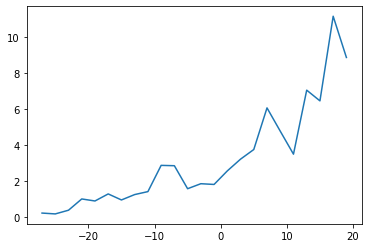

In [105]:
plt.plot(bin_DT_cent, pr_binned[:,2,800,10])

### Calculate Scaling Rates on grid cell level

In [108]:
# fit exponential curves to data to estimate scaling rates
scaling_rate = np.zeros((Lon.shape[0], Lon.shape[1])); scaling_rate[:] = np.nan
scaling_rate_std = np.copy(scaling_rate)

from scipy.optimize import curve_fit
def func(x, li, sc):
    return li * (1+sc)**x

pool = 0
for la in tqdm(range(pool, Lon.shape[0]-pool-1, 1)):
    for lo in range(pool, Lon.shape[1]-pool-1, 1):
        peak_x = bin_DT_cent
        peak_y = pr_binned[:,2,la-pool:la+pool+1,lo-pool:lo+pool+1].flatten()
        FIN = ~np.isnan(peak_y)
        try:
            popt, pcov = curve_fit(func, peak_x[FIN], peak_y[FIN], maxfev=800, p0 = [22,0.07])
            perr = np.sqrt(np.diag(pcov))
            scaling_rate[la,lo] = popt[1]*100
            scaling_rate_std[la,lo] = perr[1]*100
        except:
            continue

  0%|          | 0/1014 [00:00<?, ?it/s]/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 1014/1014 [00:08<00:00, 126.22it/s]


### Save the data for future processing

In [55]:
save_file = SaveFolder+'Gridcell-scaling_'+str(TimeMM[0].year)+'-'+str(TimeMM[-1].year)+'_section_'+str(SEC)+'.npz'
np.savez(save_file,
         TimeHH = TimeHH,
         SEC = SEC,
         Lon = Lon,
         Lat = Lat,
         bins_dT = bins_dT,
         pr_binned = pr_binned,
         pr_perc = pr_perc,
         dry_threshold = dry_threshold,
         scaling_rate = scaling_rate,
         scaling_rate_std = scaling_rate_std)
         